# **Detection Object Class "Person"**


### **Import dependencies**

In [ ]:
from os import rmdir
rmdir("/content/dataset")

OSError: ignored

In [ ]:
import os
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt

### **Load dataset from roboflow**

In [ ]:
!pip install roboflow

In [ ]:
# Error con la forma en que se carga el dataset, pero sirve como ejemplo
# from roboflow import Roboflow
# rf = Roboflow(api_key="nOBDLv9PgZPpeDZ2aH0E")
# # project = rf.workspace("tank-detect").project("person-dataset-kzsop")
# # dataset = project.version(4).download("tensorflow")

# project2 = rf.workspace("trisha-then").project("human-detection-cctv")
# dataset2 = project2.version(10).download("tensorflow")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Human-Detection-(CCTV)-10 in tensorflow:: 100%|██████████| 1871/1871 [00:00<00:00, 2678.93it/s]


In [ ]:
!cp -r "/content/drive/My Drive/dataset" "/content/"

In [ ]:
for dirname, _, filenames in os.walk('dataset'):
    print(dirname)

dataset
dataset/Person
dataset/Animal


In [ ]:
!pip install split-folders

In [ ]:
import splitfolders

In [ ]:
splitfolders.ratio(
    "dataset", output="data_splited",
    ratio=(0.8, 0.1, 0.1),
    move=True
)

Copying files: 5831 files [00:02, 2911.70 files/s]


In [ ]:
for dirname, _, filenames in os.walk('data_splited'):
    print(dirname)

data_splited
data_splited/test
data_splited/test/Person
data_splited/test/Animal
data_splited/train
data_splited/train/Person
data_splited/train/Animal
data_splited/val
data_splited/val/Person
data_splited/val/Animal


In [ ]:
base_dir = 'data_splited'
classes = ['Person','Animal']

trainDir = {
    'train_dir': os.path.join(base_dir, 'train')
}

valDir = {
    'val_dir': os.path.join(base_dir, 'val')
}

testDir = {
    'test_dir': os.path.join(base_dir, 'test')
}

for class_name in classes:
  trainDir[class_name] = os.path.join(trainDir['train_dir'], class_name)
  valDir[class_name] = os.path.join(valDir['val_dir'], class_name)
  testDir[class_name] = os.path.join(testDir['test_dir'], class_name)




In [ ]:
total = 0
for class_name in classes:
    num_tr = len(os.listdir(trainDir[class_name]))
    num_vl = len(os.listdir(valDir[class_name]))
    num_ts = len(os.listdir(testDir[class_name]))
    total = num_tr + num_vl + num_ts
    print(f'\nNumber of {class_name} images in the dataset: {total}')
    print('\u2022 {:,} training set'.format(num_tr))
    print('\u2022 {:,} validation set'.format(num_vl))
    print('\u2022 {:,} testing set'.format(num_ts))




Number of Person images in the dataset: 3269
• 2,615 training set
• 326 validation set
• 328 testing set

Number of Animal images in the dataset: 2562
• 2,049 training set
• 256 validation set
• 257 testing set


In [ ]:
BATCH_SIZE = 64
IMG_SIZE = 224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE)

Found 4664 images belonging to 2 classes.


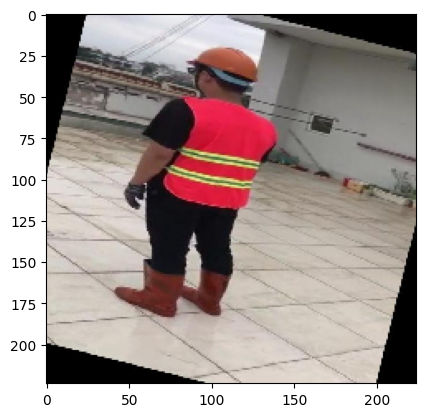

<class 'keras.src.preprocessing.image.DirectoryIterator'>


In [ ]:
image_gen = ImageDataGenerator(rescale=1./255)
img = image_gen.flow_from_directory(directory=trainDir['train_dir'], batch_size=BATCH_SIZE, shuffle=True, target_size=IMG_SHAPE, class_mode='binary')
plt.imshow(img[0][0][0])
plt.show()
print(type(img))


In [ ]:
def plot_images(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [ ]:

image_gen_train = ImageDataGenerator(rescale=1./255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     vertical_flip=True,
                                     fill_mode='nearest')

train_data_gen = image_gen_train.flow_from_directory(directory=trainDir['train_dir'],
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=IMG_SHAPE,
                                                     class_mode='binary')

Found 4664 images belonging to 2 classes.


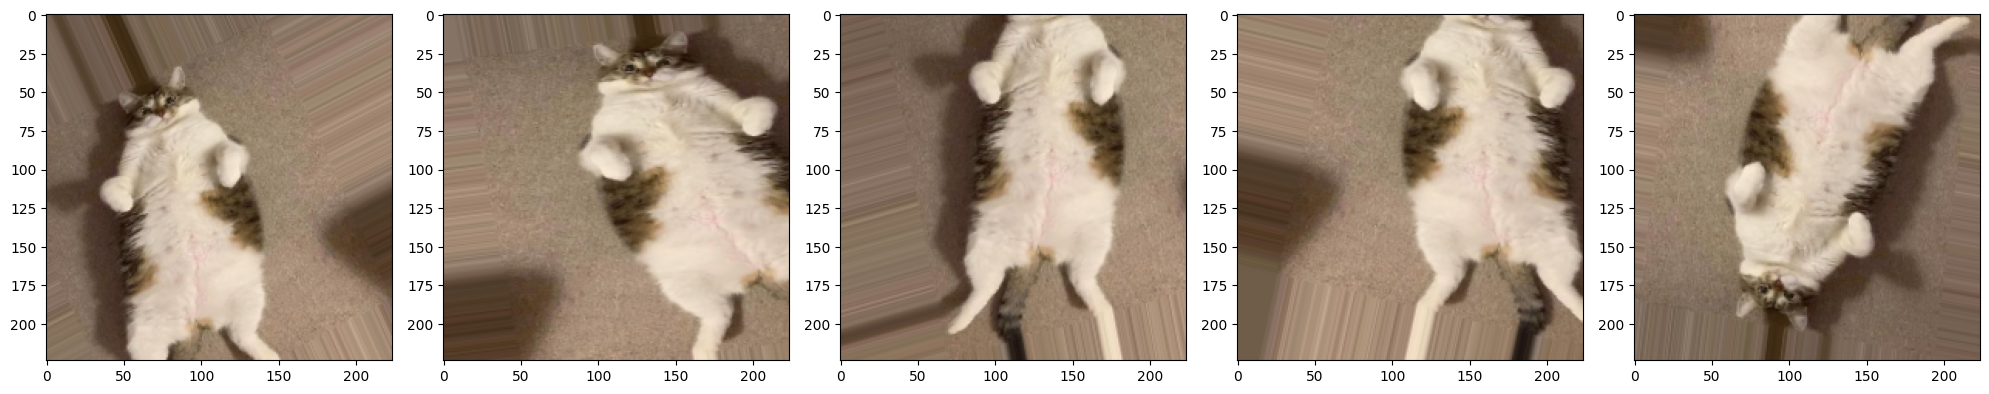

In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plot_images(augmented_images)

In [ ]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(directory=valDir['val_dir'],
                                                 batch_size=BATCH_SIZE,
                                                 target_size=IMG_SHAPE,
                                                 class_mode='binary')

test_data_gen = image_gen_val.flow_from_directory(directory=testDir['test_dir'],
                                                  batch_size=BATCH_SIZE,
                                                  target_size=IMG_SHAPE,
                                                  class_mode='binary')

Found 581 images belonging to 2 classes.
Found 585 images belonging to 2 classes.


In [ ]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL, input_shape=(IMG_SIZE, IMG_SIZE, 3))
feature_extractor.trainable = False

In [ ]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten
from tensorflow.keras import Sequential

red = Sequential()

red.add(feature_extractor)
red.add(Dense(2, activation='softmax'))

red.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [ ]:
red.compile(
    optimizer='adam',
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)

In [ ]:

# Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=7)
# Save the best model
save_best_model = tf.keras.callbacks.ModelCheckpoint('./best_model.h5',
                                                     monitor='val_loss',
                                                     save_best_only=True)

Epoch 1/15
73/73 [==============================] - 289s 4s/step - loss: 0.1042 - accuracy: 0.9648 - val_loss: 0.0629 - val_accuracy: 0.9793
Epoch 2/15
73/73 [==============================] - 288s 4s/step - loss: 0.0720 - accuracy: 0.9771 - val_loss: 0.0455 - val_accuracy: 0.9845
Epoch 3/15
73/73 [==============================] - 294s 4s/step - loss: 0.0562 - accuracy: 0.9824 - val_loss: 0.0423 - val_accuracy: 0.9811
Epoch 4/15
73/73 [==============================] - 285s 4s/step - loss: 0.0452 - accuracy: 0.9852 - val_loss: 0.0323 - val_accuracy: 0.9880
Epoch 5/15
73/73 [==============================] - 297s 4s/step - loss: 0.0450 - accuracy: 0.9848 - val_loss: 0.0303 - val_accuracy: 0.9897
Epoch 6/15
73/73 [==============================] - 287s 4s/step - loss: 0.0335 - accuracy: 0.9895 - val_loss: 0.0329 - val_accuracy: 0.9845
Epoch 7/15
73/73 [==============================] - 297s 4s/step - loss: 0.0292 - accuracy: 0.9916 - val_loss: 0.0243 - val_accuracy: 0.9880
Epoch 8/15
73

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


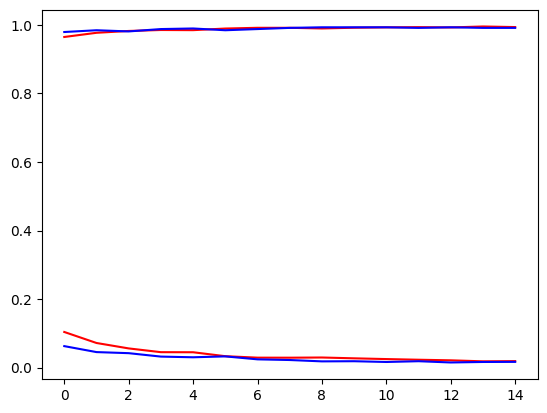

In [ ]:
r = red.fit(
    train_data_gen,
    validation_data = val_data_gen,
    epochs = 15,
)
plt.plot(r.history['loss'], color = 'red', label = 'loss')
plt.plot(r.history['val_loss'], color = 'blue', label = 'val_loss')
plt.plot(r.history['accuracy'] , color = 'red' , label = 'loss')
plt.plot(r.history['val_accuracy'] , color = 'blue' , label = 'val_loss')

red.save("ObjectDetected.h5")

<Axes: >

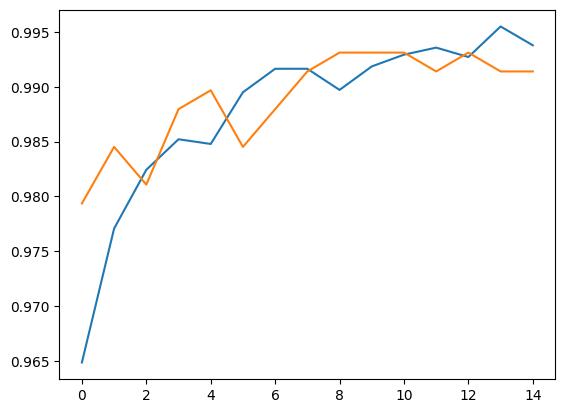

In [ ]:
import pandas as pd

datos = pd.DataFrame(r.history)
#certitud
datos.accuracy.plot()
datos.val_accuracy.plot()

<Axes: >

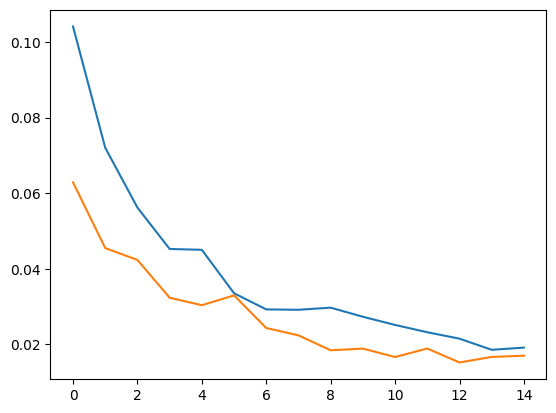

In [ ]:
datos.loss.plot()
datos.val_loss.plot()

In [ ]:
predicts = red.predict(test_data_gen)
predicts

5/5 [==============================] - 1s 219ms/step


array([[9.99997258e-01, 2.75674188e-06],
       [4.48812672e-04, 9.99551117e-01],
       [1.25066208e-05, 9.99987483e-01],
       [3.57156154e-04, 9.99642849e-01],
       [9.16510908e-06, 9.99990821e-01],
       [4.54046158e-03, 9.95459497e-01],
       [9.99512911e-01, 4.87084151e-04],
       [9.73443559e-04, 9.99026537e-01],
       [3.47721012e-04, 9.99652267e-01],
       [9.99218225e-01, 7.81726209e-04],
       [9.99297857e-01, 7.02176825e-04],
       [9.91473675e-01, 8.52630939e-03],
       [1.34442831e-04, 9.99865532e-01],
       [1.32121349e-05, 9.99986768e-01],
       [9.99273717e-01, 7.26307917e-04],
       [2.70119542e-03, 9.97298777e-01],
       [2.49504283e-05, 9.99975085e-01],
       [9.99887466e-01, 1.12576461e-04],
       [2.52357277e-04, 9.99747694e-01],
       [9.99134600e-01, 8.65400187e-04],
       [1.51941713e-04, 9.99848008e-01],
       [9.99953151e-01, 4.68175385e-05],
       [9.96068001e-01, 3.93201271e-03],
       [9.85768139e-01, 1.42318495e-02],
       [1.116708

In [ ]:
loss, accuracy = red.evaluate(test_data_gen)
print('Loss and Accuracy on Testing Data')
print('Loss: {}'.format(loss))
print('Accuracy: {}'.format(accuracy))

10/10 [==============================] - 25s 2s/step - loss: 0.0363 - accuracy: 0.9915
Loss and Accuracy on Testing Data
Loss: 0.03634950518608093
Accuracy: 0.9914529919624329
